<a href="https://colab.research.google.com/github/anitalp/Music_Genre_Classification/blob/master/Marcos_Ignacio_Ex2_1approach_IMMUNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the GZAN genres set for this excercise.
We start importing all libraries needed for our genre classifier.

In [ ]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import keras

import warnings
warnings.filterwarnings('ignore')

Now we create an algorythm so we can use the GPU and boost our computation capabilities.

In [ ]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


Its time to extract from our songs their spectrogram, a visual map of their frequencies spectrum in a short period or segment, so later we may be able to extract relevant features.

In [ ]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./data/genres/{g}'):
        songname = f'./data/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
 

<Figure size 720x720 with 0 Axes>

Based on the spectogram results, now we can extract the MFCC´s coefficients plus other important and differencial features.

In [ ]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Once we have extract these features, which will help us to classified, lets say objectively, our music in different genres, we should create a new .csv file with all of them properly organized by song, and defining their label. Label will be our target.

In [ ]:
file = open('data_MYMUSIC.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./data/genres/{g}'):
        songname = f'./data/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=20)
        #to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data_MYMUSIC.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

We print our collected data:

In [ ]:
data = pd.read_csv('data_MYMUSIC.csv')
data

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,42.351032,...,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,blues.00001.wav,0.340983,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,35.874687,...,5.376803,-2.239120,4.216963,-6.012273,0.936109,-0.716537,0.293876,-0.287431,0.531573,blues
2,blues.00002.wav,0.363603,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,31.689013,...,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,26.871927,...,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,22.153301,...,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,0.351991,2008.581132,2106.617024,4254.215942,0.089267,-153.632309,109.857262,-23.085709,59.040672,...,12.350818,-12.306271,5.780973,-10.279924,1.791489,-13.304210,2.473193,-6.717574,-1.189238,rock
996,rock.00096.wav,0.398653,2006.051164,2068.327905,4147.374921,0.097659,-142.424210,116.219780,-32.177074,49.122971,...,14.065345,-16.394691,4.152589,-4.350760,3.736455,-10.845638,1.875218,-7.459579,-2.802677,rock
997,rock.00097.wav,0.432103,2077.190361,1926.989678,4030.767293,0.121824,-125.031326,115.194977,-47.993507,52.834530,...,10.481961,-17.951916,1.211113,-11.534864,1.844774,-12.847901,3.447425,-12.594178,-2.107002,rock
998,rock.00098.wav,0.362349,1398.672358,1818.148469,3014.740104,0.048731,-224.972305,123.656891,-9.754534,56.595062,...,7.683082,-10.071787,-0.255098,-5.276486,-2.816288,-4.416438,1.558265,-5.043121,-3.585596,rock


In [ ]:
data = data.drop(['filename'],axis=1)

Now we encode the labels into categorical integers:

In [ ]:
genre_list = data.iloc[:, -1] #-1
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

And we scale all features btw range 1 and -1. Now all coefficients will be normalized. 

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-2], dtype = float))  #-1

In [ ]:
X

array([[-0.35174835, -0.58330334, -0.45603703, ...,  0.50028706,
        -0.23719143,  0.00761125],
       [-0.46146555, -0.93906628, -0.38766764, ...,  0.71473745,
        -0.05518971,  0.54382356],
       [-0.18448354, -0.90741936, -0.94167974, ..., -0.82655262,
        -0.60070696, -0.29428465],
       ...,
       [ 0.6543177 , -0.17418012, -0.59985796, ..., -1.95244951,
         0.76028073, -2.73474442],
       [-0.19983743, -1.12235633, -0.80675114, ..., -0.09871815,
         0.27176634, -0.72311177],
       [-0.25070237, -0.82782084, -0.84682792, ..., -0.68221609,
        -0.1250688 ,  0.08171812]])

Now we need to split our data into train and test samples. We will follow the traditional approach, 80 % for training ans 20 % for testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Its time to build our classification model. We will use Keras. The activation function, since our purpose is based on a single label targeted but multiple classes to work with, is 'softmax'.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Our cicle has 20 epochs to perform training and we divide our training set into 128 mini batches.

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
800/800 [==============================] - 0s 152us/step - loss: 2.1674 - accuracy: 0.2163
Epoch 2/20
800/800 [==============================] - 0s 19us/step - loss: 1.8568 - accuracy: 0.3663
Epoch 3/20
800/800 [==============================] - 0s 21us/step - loss: 1.6319 - accuracy: 0.4150
Epoch 4/20
800/800 [==============================] - 0s 21us/step - loss: 1.4701 - accuracy: 0.4725
Epoch 5/20
800/800 [==============================] - 0s 21us/step - loss: 1.3525 - accuracy: 0.5200
Epoch 6/20
800/800 [==============================] - 0s 25us/step - loss: 1.2492 - accuracy: 0.5663
Epoch 7/20
800/800 [==============================] - 0s 21us/step - loss: 1.1621 - accuracy: 0.6162
Epoch 8/20
800/800 [==============================] - 0s 19us/step - loss: 1.0921 - accuracy: 0.6288
Epoch 9/20
800/800 [==============================] - 0s 20us/step - loss: 1.0283 - accuracy: 0.6612
Epoch 10/20
800/800 [==============================] - 0s 20us/step - loss: 0.9819 - accur

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

200/200 [==============================] - 0s 244us/step


In [ ]:
print('test_acc: ',test_acc)

test_acc:  0.7200000286102295


Test accuracy is a bit higher than our loss, so we think we are heading in a good direction, avoiding overfitting.

That is why we approach now the validation of this approach. We split the test into 200 samples for validation.

In [ ]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 600 samples, validate on 200 samples
Epoch 1/30
600/600 [==============================] - 0s 335us/step - loss: 2.2911 - accuracy: 0.1383 - val_loss: 2.1982 - val_accuracy: 0.3150
Epoch 2/30
600/600 [==============================] - 0s 17us/step - loss: 2.1764 - accuracy: 0.3367 - val_loss: 2.1019 - val_accuracy: 0.3550
Epoch 3/30
600/600 [==============================] - 0s 17us/step - loss: 2.0676 - accuracy: 0.3933 - val_loss: 1.9898 - val_accuracy: 0.3650
Epoch 4/30
600/600 [==============================] - 0s 17us/step - loss: 1.9384 - accuracy: 0.4067 - val_loss: 1.8866 - val_accuracy: 0.3750
Epoch 5/30
600/600 [==============================] - 0s 17us/step - loss: 1.8118 - accuracy: 0.4250 - val_loss: 1.7799 - val_accuracy: 0.3800
Epoch 6/30
600/600 [==============================] - 0s 17us/step - loss: 1.6848 - accuracy: 0.4383 - val_loss: 1.6796 - val_accuracy: 0.3700
Epoch 7/30
600/600 [==============================] - 0s 20us/step - loss: 1.5680 - accuracy: 0

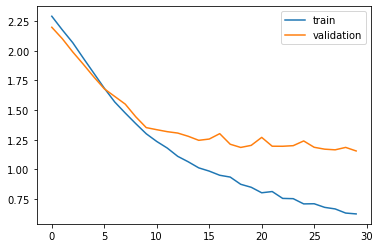

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Our plot and results shows we don´t have the perfect learning, but there is no much overfitting. We decide to get on board a new song and see how the learner performs.

In [ ]:
results

[1.0412772846221925, 0.6349999904632568]

The elected is a song we both know as a clear rock potent song. We process it as we did arlier with the songs of out primal set,
we extract its spectrogram, features coefficients and create a new .csv with it.

In [ ]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
songname = f'./data/music_examples/temple_of_love-sisters_of_mercy.wav'
y, sr = librosa.load(songname, mono=True, duration=5)
plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
plt.axis('off');
plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
plt.clf()
 

<Figure size 720x720 with 0 Axes>

In [ ]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('data_MYMUSIC2.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
songname = f'./data/music_examples/temple_of_love-sisters_of_mercy.wav'
y, sr = librosa.load(songname, mono=True, duration=30)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
#to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
to_append = f'temple_of_love-sisters_of_mercy.wav {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
for e in mfcc:
        to_append += f' {np.mean(e)}'
file = open('data_MYMUSIC2.csv', 'a', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())

In [ ]:
mfcc

array([[-531.8293   , -531.8293   , -531.8293   , ...,  -41.77591  ,
         -59.718346 ,  -72.18314  ],
       [   0.       ,    0.       ,    0.       , ...,   79.5217   ,
          91.169266 ,   93.27377  ],
       [   0.       ,    0.       ,    0.       , ...,    8.179108 ,
           9.071305 ,    7.4184675],
       ...,
       [   0.       ,    0.       ,    0.       , ...,    9.605041 ,
           4.1489873,    1.817771 ],
       [   0.       ,    0.       ,    0.       , ...,    3.6372166,
           3.0379376,   -3.5994864],
       [   0.       ,    0.       ,    0.       , ...,   -1.007509 ,
          -1.6507684,   -6.283662 ]], dtype=float32)

In [ ]:
data2 = pd.read_csv('data_MYMUSIC2.csv')

In [ ]:
data2.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,temple_of_love-sisters_of_mercy.wav,0.39218,3012.281226,2700.981659,5917.69755,0.156523,-66.154366,63.343739,-5.757527,35.341484,...,-3.295837,-3.521336,-6.336587,1.551449,-1.498453,-4.331505,-3.654512,-5.877038,-2.983863,NaN


In [ ]:
data2 = data2.drop(['filename'],axis=1)

In [ ]:
data2.shape

(1, 26)

In [ ]:
pd.concat([data,data2]).shape

(1001, 26)

In [ ]:
sample = scaler.fit_transform(np.array(pd.concat([data,data2]).iloc[:, :-2], dtype = float))  #-1

In [ ]:
sample

array([[-0.35208473, -0.58435262, -0.45696267, ...,  0.50061555,
        -0.23609779,  0.00855604],
       [-0.46185527, -0.94006558, -0.38858504, ...,  0.71517244,
        -0.05411035,  0.5447971 ],
       [-0.18473859, -0.90842311, -0.94266395, ..., -0.82688314,
        -0.59958481, -0.29335606],
       ...,
       [-0.20009995, -1.12332988, -0.80771908, ..., -0.09868718,
         0.27282006, -0.72220617],
       [-0.25098961, -0.82883577, -0.8478007 , ..., -0.68247492,
        -0.12398395,  0.08266688],
       [ 0.16535776,  1.13124636,  0.87063596, ..., -0.08000479,
        -1.07503667, -0.94437691]])

In [ ]:
sample[-1].reshape((24,1))

array([[ 0.16535776],
       [ 1.13124636],
       [ 0.87063596],
       [ 0.85441343],
       [ 1.26315511],
       [ 0.78116853],
       [-1.15487153],
       [ 0.14585791],
       [-0.05709343],
       [ 0.03986309],
       [-1.28455644],
       [ 1.35086744],
       [-0.73378349],
       [ 0.65083682],
       [-1.39624963],
       [ 0.07792456],
       [-1.15556   ],
       [ 0.20675505],
       [-1.61842838],
       [ 1.11159335],
       [-0.57784176],
       [-0.08000479],
       [-1.07503667],
       [-0.94437691]])

In [ ]:
model.predict(sample)

array([[2.5665936e-01, 7.2072810e-03, 8.5452959e-02, ..., 6.6622449e-03,
        8.6212559e-03, 1.8962066e-01],
       [4.6373057e-01, 1.4841761e-03, 7.6374702e-02, ..., 3.9792205e-03,
        7.5299684e-03, 1.1227368e-01],
       [2.9901284e-01, 4.7294525e-04, 4.3858269e-01, ..., 6.3292315e-04,
        2.1962139e-03, 2.4524908e-01],
       ...,
       [2.0936838e-01, 1.5447293e-03, 2.3725210e-01, ..., 1.2350371e-03,
        2.0659763e-01, 3.1709397e-01],
       [9.9255688e-02, 9.3805688e-03, 3.2270318e-01, ..., 6.0608424e-04,
        3.0323051e-02, 4.1727236e-01],
       [1.5500089e-03, 4.8835581e-04, 1.5958583e-01, ..., 5.5244349e-02,
        1.7640660e-02, 5.6156480e-01]], dtype=float32)

Its time to classified the new song based on our previous learning training, crossing fingers, our accuracy is not the best.

In [ ]:
predictions = model.predict(sample)

In [ ]:
np.argmax(predictions[-1])

9

In [ ]:
genres[np.argmax(predictions[-1])]

'rock'

So it did it! Our song is a rock song, and our model knows it. Best wishes!